# Monti Carlo Simulation (PSKY) - Bootstrapping Method
Calculating Value at Risk over a longer period

* 252 Trading Days in a Year
* 63 Business Days in a Quarter
* Simulating pirces over a multi-period is called a stochastic process
* Parametric Method - assumes normality of returns (i.e. normaly distributed)
    * Assumes Daily returns are independent from each other
* Bootstrapping Method - does not assume normality of returns and works with the actual distribution of the histoircal returns

#### Problem Definition: 

For a $1Mil position on PSKY, simulate the minimum loss over a period of one quarter that will occur with 1% probability: 1% VaR of $1M USD over a period of one quarter (63 business days). Use the parametric method

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("seaborn-v0_8")

In [2]:
class FinancialInstrument():
    ''' Class for analyzing Financial Instruments like stocks.

    Attributes
    ==========
    ticker: str
        ticker symbol with which to work with
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval

    Methods
    =======
    get_data:
        retrieves daily price data (from yahoo finance) and prepares the data
    log_returns:
        calculates log returns
    plot_prices:
        creates a price chart
    plot_returns:
        plots log returns either as time series ("ts") or histogram ("hist")
    set_ticker:
        sets a new ticker
    mean_return:
        calculates mean return
    std_returns:
        calculates the standard deviation of returns (risk)
    annualized_perf:
        calculates annulized return and risk
    '''
    
    def __init__(self, ticker, start, end):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.get_data()
        self.log_returns()
    
    def __repr__(self): 
        return "FinancialInstrument(ticker = {}, start = {}, end = {})".format(self.ticker, 
                                                                               self.start, self.end)
    def get_data(self):
        ''' retrieves (from yahoo finance) and prepares the data
        '''
        raw = yf.download(self.ticker, self.start, self.end, multi_level_index = False).Close.to_frame() # new from yfinance 0.2.48
        raw.rename(columns = {"Close":"price"}, inplace = True)
        self.data = raw
        
    def log_returns(self):
        '''calculates log returns
        '''
        self.data["log_returns"] = np.log(self.data.price/self.data.price.shift(1))
        
    def plot_prices(self):
        ''' creates a price chart
        '''
        self.data.price.plot(figsize = (12, 8))
        plt.title("Price Chart: {}".format(self.ticker), fontsize = 15)
    
    def plot_returns(self, kind = "ts"):
        ''' plots log returns either as time series ("ts") or histogram ("hist")
        '''
        if kind == "ts":
            self.data.log_returns.plot(figsize = (12, 8))
            plt.title("Returns: {}".format(self.ticker), fontsize = 15)
        elif kind == "hist":
            self.data.log_returns.hist(figsize = (12, 8), bins = int(np.sqrt(len(self.data))))
            plt.title("Frequency of Returns: {}".format(self.ticker), fontsize = 15)
    
    def set_ticker(self, ticker = None):
        '''sets a new ticker
        '''
        if ticker is not None:
            self.ticker = ticker
            self.get_data()
            self.log_returns()
            
    def mean_return(self, freq = None):
        '''calculates mean return
        '''
        if freq is None:
            return self.data.log_returns.mean()
        else:
            resampled_price = self.data.price.resample(freq).last()
            resampled_returns = np.log(resampled_price / resampled_price.shift(1))
            return resampled_returns.mean()
    
    def std_returns(self, freq = None):
        '''calculates the standard deviation of returns (risk)
        '''
        if freq is None:
            return self.data.log_returns.std()
        else:
            resampled_price = self.data.price.resample(freq).last()
            resampled_returns = np.log(resampled_price / resampled_price.shift(1))
            return resampled_returns.std()
        
    def annualized_perf(self):
        '''calculates annulized return and risk
        '''
        mean_return = round(self.data.log_returns.mean() * 252, 3)
        risk = round(self.data.log_returns.std() * np.sqrt(252), 3)
        print("Return: {} | Risk: {}".format(mean_return, risk))

In [3]:
stock = FinancialInstrument(ticker = "PSKY", start = "2000-01-01", 
                            end =  "2025-12-31" ) # instantiation

[*********************100%***********************]  1 of 1 completed


In [4]:
# exporting data to csv
#stock.data.to_csv("PSKY_data.csv")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
np.set_printoptions(precision=4, suppress=True)

In [6]:
returns = stock.data.log_returns.dropna().values

In [7]:
returns

array([-0.0358, -0.0082, -0.0063, ..., -0.0059,  0.0154, -0.011 ],
      shape=(5046,))

In [8]:
#returns.size

In [9]:
IO = 100
sims = 10000
days = 63

In [10]:
def path_simul_bootsstr(daily_returns, days, IO, sims = 10000, seed = 123):

    days  = int(days)

    np.random.seed(seed)
    ret = np.random.choice(daily_returns, size=(days * sims), replace=True).reshape(sims, days)

    paths = (ret + 1).cumprod(axis = 1) * IO
    paths = np.hstack((np.ones(sims).reshape(sims, 1) * IO, paths))

    return paths

In [11]:
paths = path_simul_bootsstr(returns, days = days, IO = IO, sims = sims)
paths

array([[100.    ,  94.8079,  96.4113, ..., 104.3603, 104.7362, 104.6461],
       [100.    ,  95.9769,  97.4277, ..., 101.1495, 101.4748, 103.2758],
       [100.    , 100.4573,  99.9505, ...,  92.6423,  94.1701,  97.8948],
       ...,
       [100.    ,  80.4138,  79.2922, ...,  88.8492,  88.9797,  89.4186],
       [100.    ,  99.1024,  98.6562, ..., 119.7845, 124.3248, 122.7778],
       [100.    ,  98.6244, 100.8443, ...,  89.9045,  71.5297,  74.0631]],
      shape=(10000, 64))

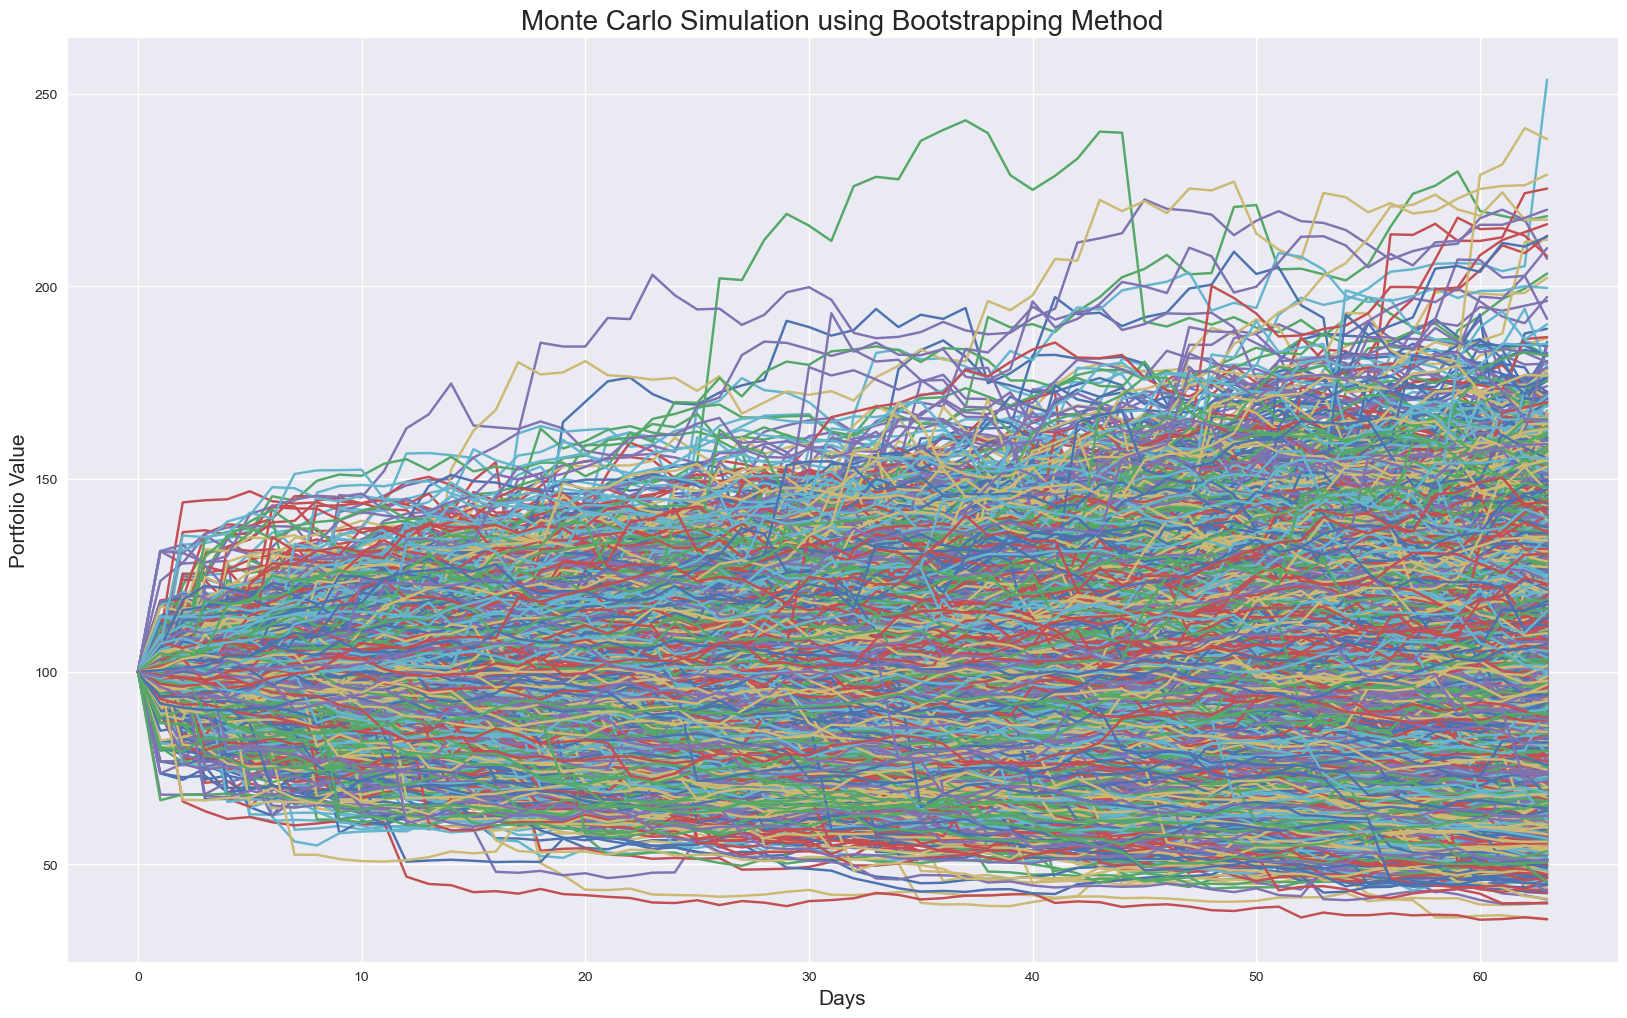

In [12]:
plt.figure(figsize=(20, 12))
plt.plot(paths.T)
plt.ylabel("Portfolio Value", fontsize=15)
plt.xlabel("Days", fontsize=15)
plt.title("Monte Carlo Simulation using Bootstrapping Method", fontsize=20)
plt.show()

In [13]:
# 1 million simulations
IO = 1000000
sims = 1000000
days = 63

In [14]:
paths = path_simul_bootsstr(returns, days = days, IO = IO, sims = sims)

In [15]:
final_b = paths[:,-1]

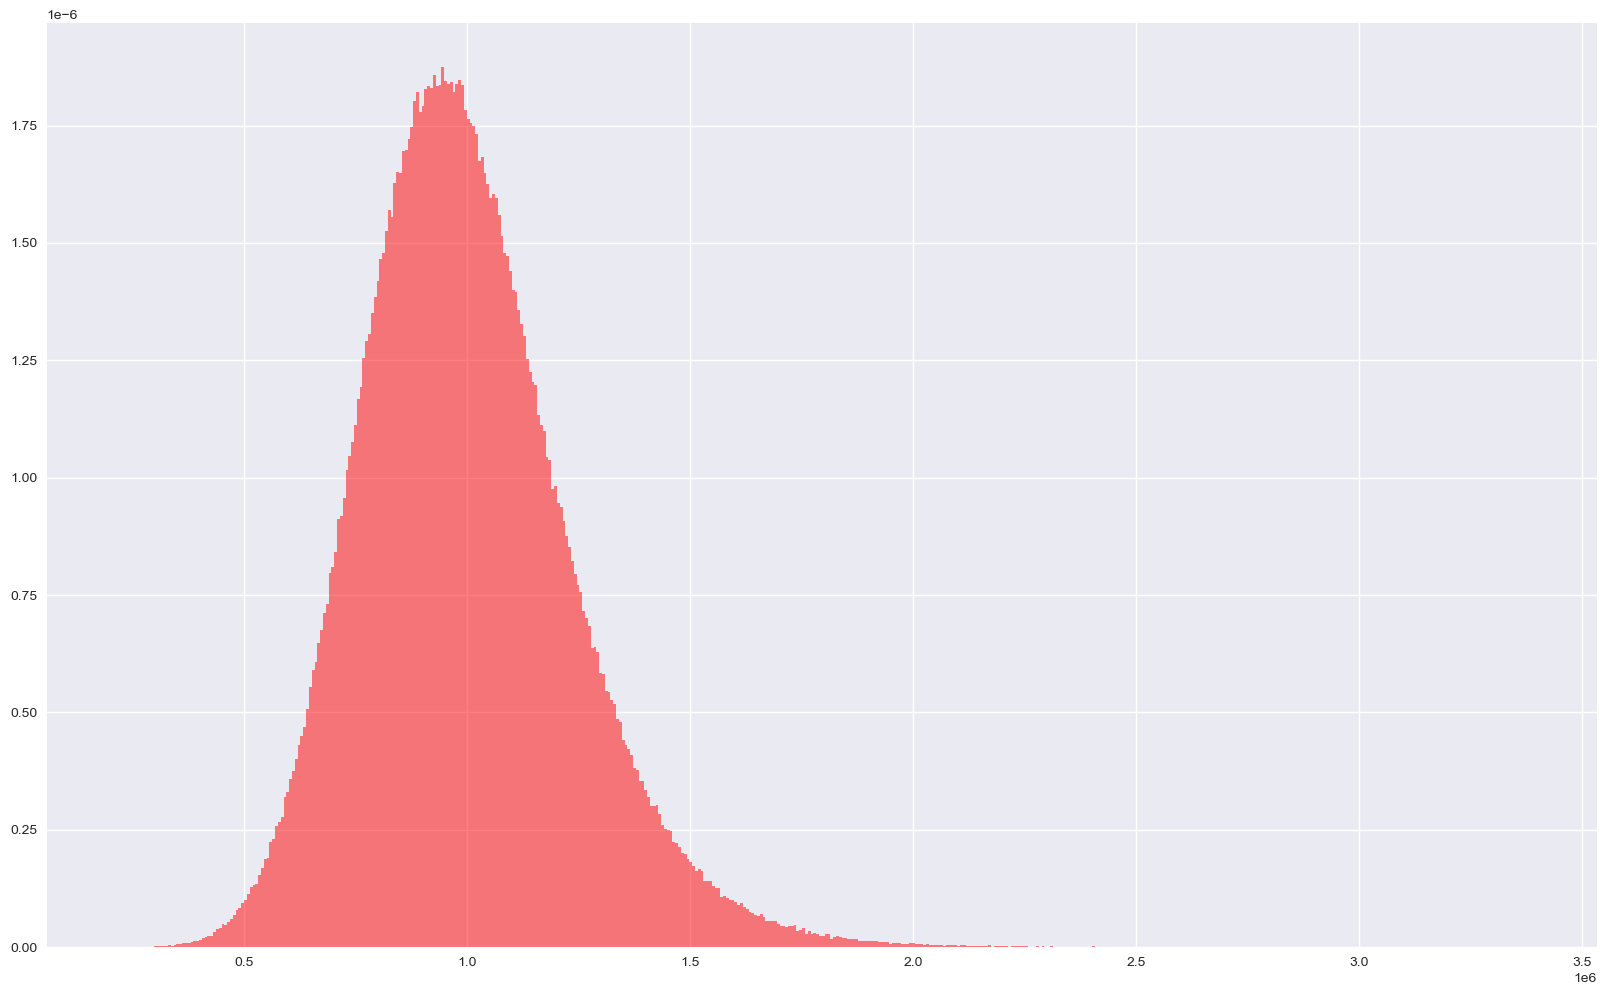

In [16]:
plt.figure(figsize=(20, 12))
plt.hist(final_b, bins=500, density=True, alpha=0.5, color='r')
#plt.hist(final_p, bins=1000, density=True, alpha=0.5, color='b') # need to combine from parametric method workbook
plt.show()

In [17]:
final_b.mean()

np.float64(997205.508779033)

In [18]:
np.mean(final_b)

np.float64(997205.508779033)

In [19]:
final_b.std()

np.float64(233471.73052746488)

In [20]:
stats.skew(final_b)

np.float64(0.6538690862199813)

#### 1% VaR of $1 Mil USD over a period of one quarter

In [21]:
IO = 1000000
prob = 0.01

In [22]:
final_b

array([1046461.1869, 1032758.4762,  978948.3184, ..., 1357573.4386,
        761507.4341, 1460192.1377], shape=(1000000,))

In [23]:
final_b.size

1000000

In [24]:
#VaR bootstrapping method
np.percentile(final_b, prob*100) - IO

np.float64(-463711.9068092499)

In [25]:
#VaR parametric method - from other workbook
#np.percentile(final_p, prob*100) - IO

VaR parametric method - from other workbook: np.float64(-433953.15249725105)

bootstrapping VaR is higher than Parametric method becuase bootstrapping does not assume normality of returns and takes into account the fat tail of financial returns

In [26]:
def var_bootstr(daily_returns, days, IO, prob, sims = 10000, seed = 123):
    
    days  = int(days)
    
    np.random.seed(seed)
    ret = np.random.choice(daily_returns, size=(days * sims), replace=True).reshape(sims, days)

    paths = (ret + 1).prod(axis = 1) * IO
    var = np.percentile(paths, prob*100) - IO
    
    return var

In [27]:
var_bootstr(returns, days = 63, IO = 1000000, prob = 1, sims = 1000000)

np.float64(2375534.5118531333)

In [28]:
var_b1 = []
for i in range(1, 252+1):
    var_b1.append(-var_bootstr(returns, days = i, IO = 1000000, prob = 1))

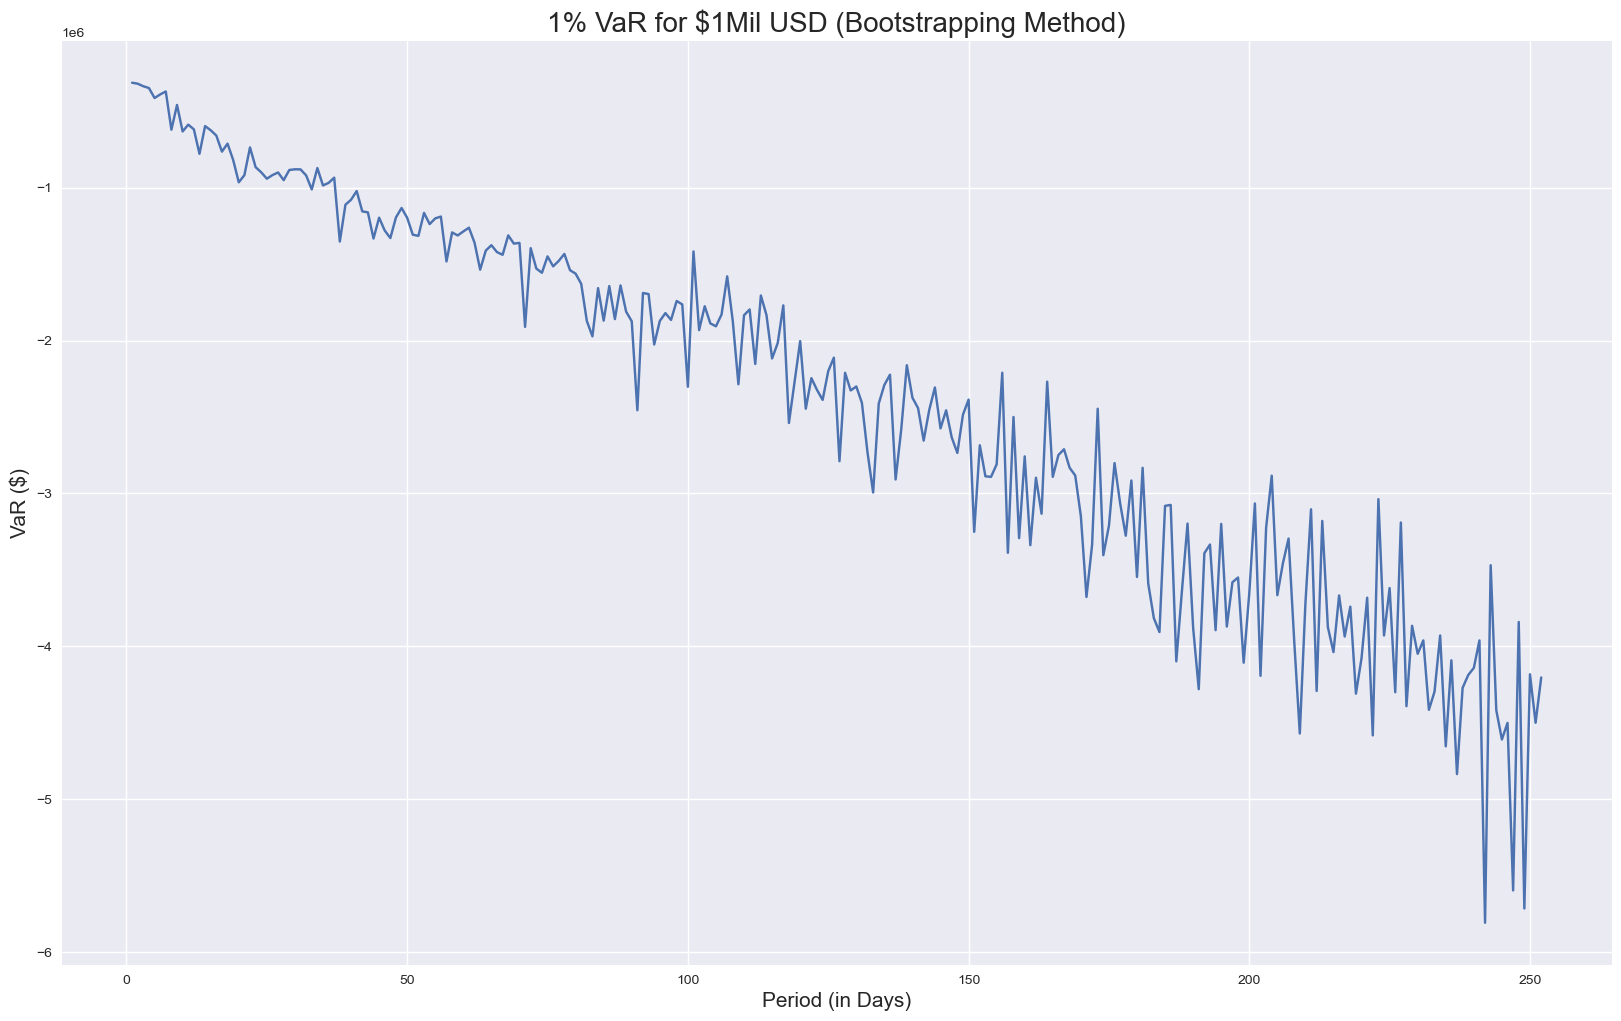

In [29]:
plt.figure(figsize=(20, 12))
plt.plot(range(1, 252+1), var_b1)
plt.title("1% VaR for $1Mil USD (Bootstrapping Method)", fontsize=20)
plt.xlabel("Period (in Days)", fontsize=15)
plt.ylabel("VaR ($)", fontsize=15)
plt.show()

In [36]:
var_b2 = []
for i in np.linspace(0.001, 0.05, 100):
    var_b2.append(-var_bootstr(returns, days = 63, IO = 1000000, prob = i))

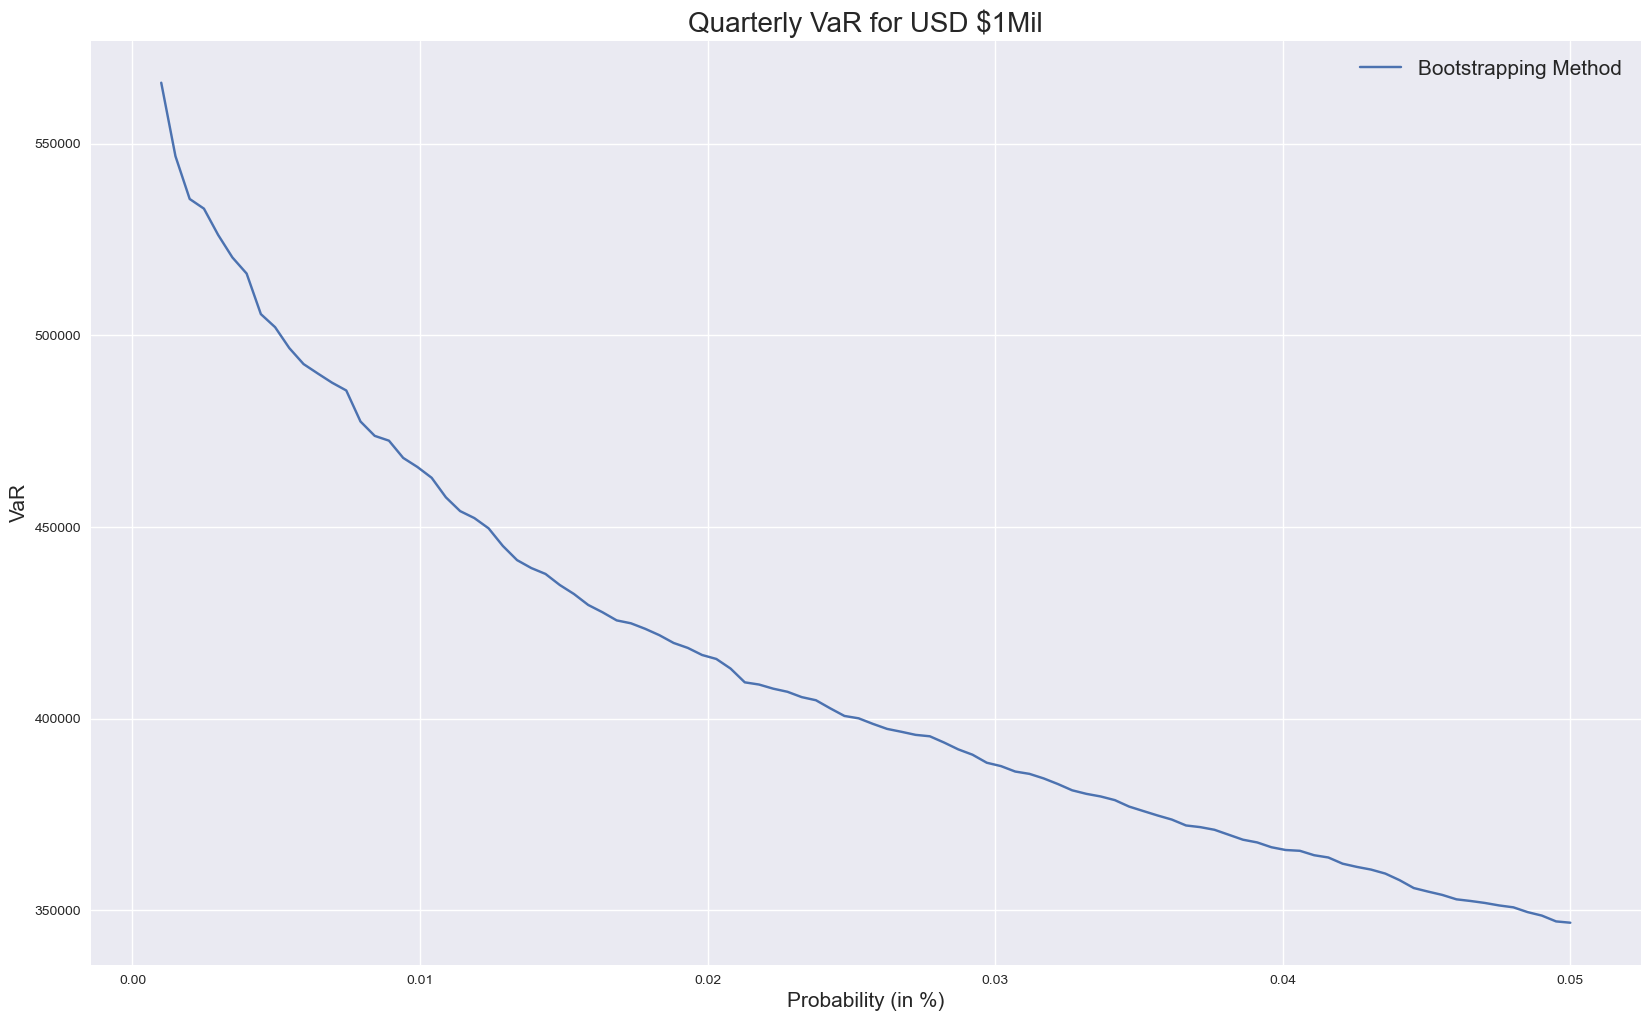

In [37]:
plt.figure(figsize=(20, 12))
#plt.plot(np.linspace(0.001, 0.05, 100), var_p2, label='Parametric Method')
plt.plot(np.linspace(0.001, 0.05, 100), var_b2, label='Bootstrapping Method')

plt.title("1% VaR for USD $1Mil", fontsize=20)
plt.title("Quarterly VaR for USD $1Mil", fontsize=20)

plt.xlabel("Probability (in %)", fontsize=15)
plt.ylabel("VaR", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Comparison with Parametric (Example ONLY) - lower the probability, bootstrapping method is more important<br>
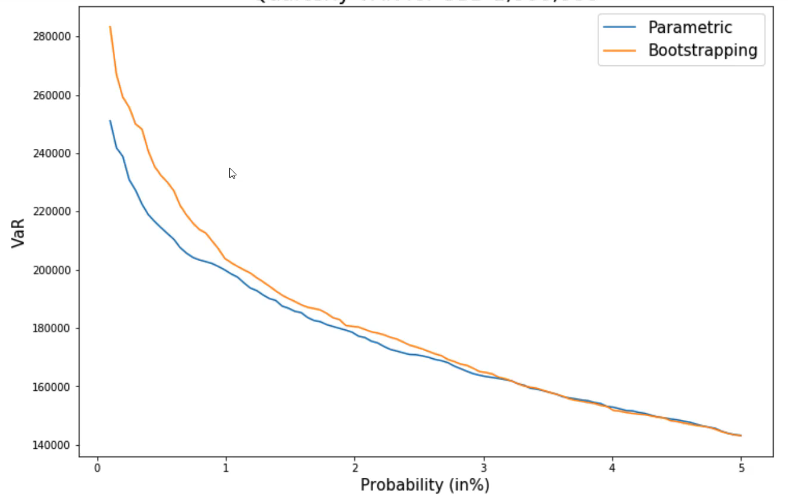